# Init

In [1]:
import cv2
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
import seaborn as sns
import skimage
import IPython
import ipywidgets

In [2]:
sns.set(style='dark')
plt.rcParams['figure.constrained_layout.use'] = True
np.set_printoptions(threshold=20, edgeitems=10, linewidth=140, precision=3, suppress=True)

In [3]:
rgb = cv2.imread('./robot.bmp')[..., ::-1]
rgb.shape, rgb.dtype

((234, 160, 3), dtype('uint8'))

In [4]:
gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
gray.shape, gray.dtype

((234, 160), dtype('uint8'))

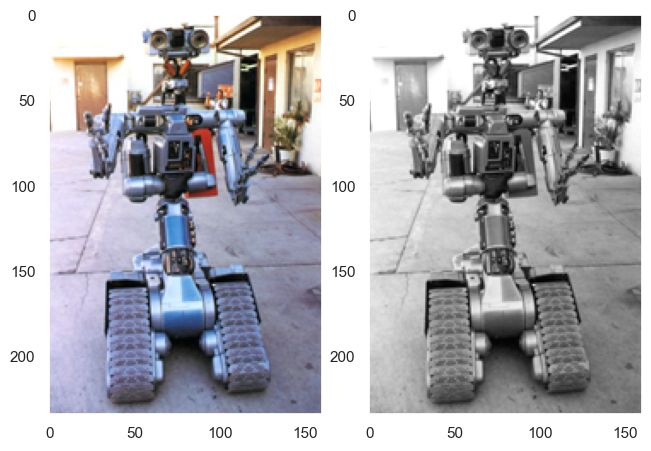

In [5]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(rgb)
axes[1].imshow(gray, cmap='gray', vmin=0, vmax=255);

# Geometric transformations

**Forward mapping (source-to-target)**

Geometric transformations modify *coordinates* of image pixels
$$
I'(T(\bold{x})) = I(\bold{x})
$$
where
- $\bold{x} = (x, y)$ are pixel coordinates,
- $T: \mathbb{R}^2 \rightarrow \mathbb{R}^2$ is a geometric mapping.

**Inverse mapping (target-to-source)**

Equivalently
$$
I'(\bold{x}') = I(T^{-1}(\bold{x}'))
$$
where
- $\bold{x}' = (x', y') = T(\bold{x})$

# Affine transformations

We may express geometric transformations as a pair of separate functions
$$
x' = T_x(x, y) \\
y' = T_y(x, y) \\
$$

A special class of transformations of the form
$$
T_x(x, y) = a_{1,1} \cdot x + a_{1,2} \cdot y + a_{1,3} \\
T_y(x, y) = a_{2,1} \cdot x + a_{2,2} \cdot y + a_{2,3}
$$
where $a_{i,j}\in\mathbb{R}$ are called **affine**. Examples of affine transformations are translation (shifting), scaling (resizing), shearing (skewing), and rotation.

# Shearing (skewing) via forward mapping

$$
x' = x + b_x \cdot y \\
y' = y + b_y \cdot x
$$
where
- $b_{\{x, y\}} = \tan(\Phi_{\{x, y\}})$ if we want to skew by a specific angle $\Phi$ in radians

In [6]:
def skew_fw(img: np.ndarray, bx: float = 0., by: float = 0.) -> np.ndarray:
    h, w = img.shape[:2]
    h_ = int(0.5 + h + w * by)
    w_ = int(0.5 + w + h * bx)
    img_ = np.zeros((h_, w_), dtype=img.dtype)
    for y in range(h):
        for x in range(w):
            x_ = int(x + y * bx)
            y_ = int(x * by + y)
            img_[y_, x_] = img[y, x]
    return img_

In [7]:
bx = 15 / 180 * np.pi
bx

0.2617993877991494

In [8]:
by = 30 / 180 * np.pi
by

0.5235987755982988

In [9]:
gray_skw = skew_fw(gray, bx=bx, by=by)
gray_skw.shape, gray_skw.dtype

((318, 221), dtype('uint8'))

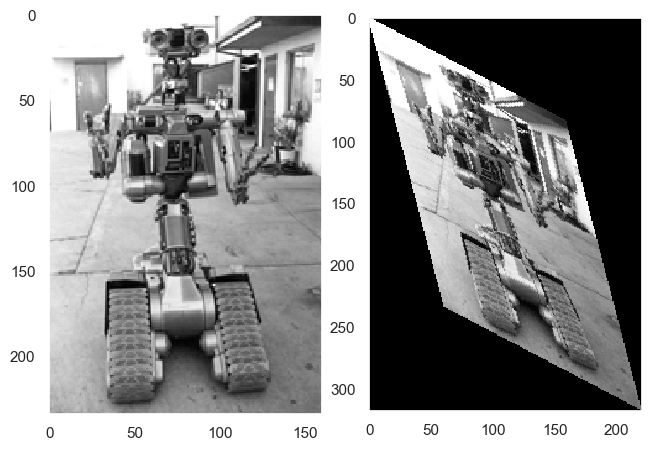

In [10]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(gray, cmap='gray', vmin=0, vmax=255, interpolation='none');
axes[1].imshow(gray_skw, cmap='gray', vmin=0, vmax=255, interpolation='none');

# Scaling via forward mapping

$$
x' = s_x \cdot x \\
y' = s_y \cdot y
$$

In [11]:
def scale_fw(img: np.ndarray, sx: float, sy: float) -> np.ndarray:
    height, width = img.shape[:2]
    height_ = int(0.5 + sy * height)
    width_ = int(0.5 + sx * width)
    img_ = np.zeros((height_, width_), dtype=img.dtype)
    for y in range(height):
        for x in range(width):
            x_ = int(0.5 + sx * x)
            y_ = int(0.5 + sy * y)
            img_[y_, x_] = img[y, x]
    return img_

In [12]:
gray_scl = scale_fw(gray, 3., 3.)
gray_scl.shape, gray_scl.dtype

((702, 480), dtype('uint8'))

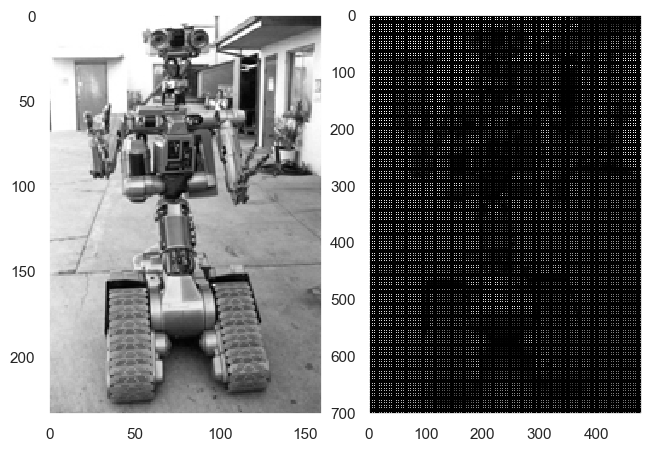

In [13]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(gray, cmap='gray', vmin=0, vmax=255, interpolation='none');
axes[1].imshow(gray_scl, cmap='gray', vmin=0, vmax=255, interpolation='none');

What happened? Let's zoom in a little bit into the scaled-up image. the problem is, of course, that the scaled-up image is larger and therefore having more pixels than the original. In our code, however, we iterate over pixels of the *original* image and then simply move them into their newly computed position. All other pixels remain unctouched, that is set to the initial value of zero.

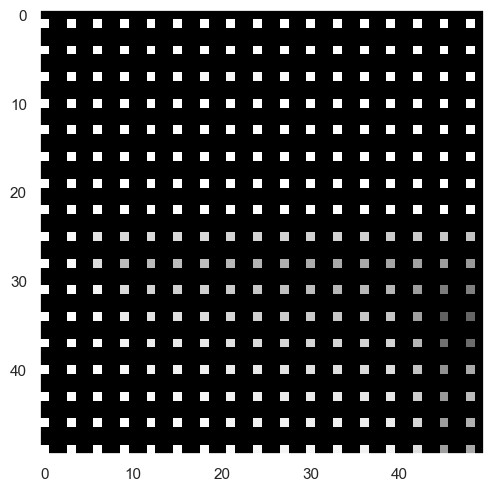

In [14]:
plt.imshow(gray_scl[50:100, :50], cmap='gray', vmin=0, vmax=255, interpolation='none');

# Homogenous coordinates

We can solve the "hole" problem above using inverse mapping. But first, we need to introduce a more convenient transformation model.

Instead of a pair of cartesian $(x, y)$ coordinates, we will express each position in an image as a *triplet* of **homogenous coordinates** $(x, y, 1)$ by appending 1 to the original pair.
$$
\begin{bmatrix}
x \\
y
\end{bmatrix}
\rightarrow
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix}
$$
Affine geometric transformations in general then become a linear matrix vector multiplication
$$
\begin{bmatrix}
x' \\
y' \\
1
\end{bmatrix}
=
\begin{bmatrix}
a_{1,1} & a_{1,2} & a_{1,3} \\
a_{2,1} & a_{2,2} & a_{2,3} \\
0 & 0 & 1
\end{bmatrix}
\cdot
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix}
$$
or for short in matrix notation
$$
\bold{x}' = \bold{A}\cdot\bold{x}
$$
Notice that for any affine transformation the last element of $\bold{x}'$ will always remain 1.

Linearity of matrix-vector multiplication will allow us to easily invert and concatenate geometric transformations, see below.

# Inverse mapping

For any non-singular affine matrix $\bold{A}$ whose last row is $[0,0,1]$ as defined above, the inverse is
$$
\bold{A}^{-1} = \frac{1}{\det\bold{A}}\begin{bmatrix}
 a_{2,2} & -a_{1,2} & a_{1,2} \cdot a_{2,3} - a_{1,3} \cdot a_{2,2} \\
-a_{2,1} &  a_{1,1} & a_{1,1} \cdot a_{2,3} - a_{1,3} \cdot a_{2,1} \\
0       & 0        & 1 \\
\end{bmatrix}
$$
where $\det{\bold{A}} = a_{1,1} \cdot a_{2, 2} - a_{1,2} \cdot a_{2,1}$ is the determinant of $\bold{A}$. This means that inverse of any affine transformation is also affine and that when computing
$$
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix}
=
\bold{A}^{-1}
\cdot
\begin{bmatrix}
x' \\
y' \\
1
\end{bmatrix}
$$
the last element of $\bold{x} = [x, y, 1]^\top$ is always guaranteed to be 1.

When we have an inverse mapping $A^{-1}$, we can iterate over pixels of the *transformed* image $I'$ instead of the original and transform each $(x',y')$ back into orignal coordinates $(x,y)$. This way are making sure that every pixel of the output image is filled with some value and is "touched" exactly once.

# Scaling via inverse mapping

In forward mapping using homogenous coordinates, scaling transformation matrix is
$$
\bold{A}
=
\begin{bmatrix}
s_x & 0 & 0 \\
0 & s_y & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

In this particular case, the inversion is
$$
\bold{A}^{-1}
=
\begin{bmatrix}
s_x^{-1} & 0 & 0 \\
0 & s_y^{-1} & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

which corresponds to cartesian coordinate transformation
$$
x = s_x^{-1} \cdot x' \\
y = s_y^{-1} \cdot y'
$$

In [15]:
def scale_inv(img: np.ndarray, sx: float, sy: float) -> np.ndarray:
    h, w = img.shape[:2]
    h_ = int(0.5 + sy * h)
    w_ = int(0.5 + sx * w)
    img_ = np.zeros((h_, w_), dtype=img.dtype)
    # iterate over the transformed coordinates
    for y_ in range(h_):
        for x_ in range(w_):
            # inverse transformation
            x = int(0.5 + x_ / sx)
            y = int(0.5 + y_ / sy)
            if x < w and y < h: 
                img_[y_, x_] = img[y, x]
    return img_

In [16]:
gray_scl = scale_inv(gray, 3., 3.)
gray_scl.shape, gray_scl.dtype

((702, 480), dtype('uint8'))

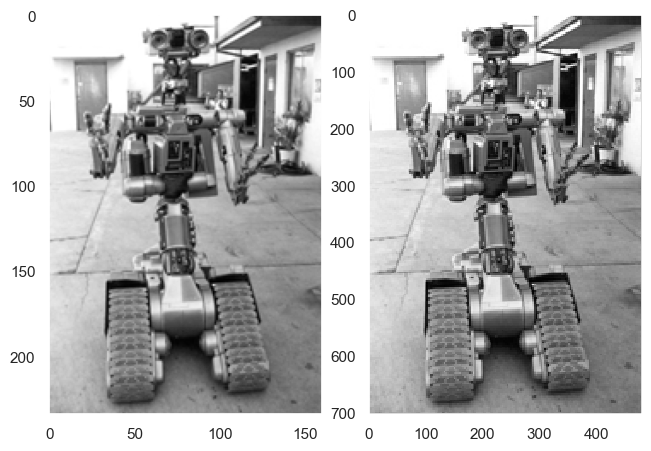

In [17]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(gray, cmap='gray', vmin=0, vmax=255);
axes[1].imshow(gray_scl, cmap='gray', vmin=0, vmax=255, interpolation='none');

# General function for affine transformations

In [18]:
def warp_affine_inv(img: np.ndarray, A: np.ndarray) -> np.ndarray:
    height, width = img.shape[:2]
    
    # get image corners and transform them
    X = np.array([0., width, width, 0.])
    Y = np.array([0., 0., height, height])
    XY = np.vstack((X, Y, np.ones(4)))
    XY_ = np.dot(A, XY)
    
    # calculate the new size
    width_ = int(XY_[0, :].max() - XY_[0, :].min())
    height_ = int(XY_[1, :].max() - XY_[1, :].min())
    img_ = np.zeros((height_, width_), dtype=img.dtype)
    
    # invert transformation
    A_inv = np.linalg.inv(A)

    # helper function to safely get a value gray[y, x]
    def src_img_at(x, y):
        if 0 <= x < width and 0 <= y < height:
            return img[y, x]
        else:
            return 0
    
    # the main transformation loop
    for y_ in range(height_):
        for x_ in range(width_):
            # inverse transform
            x, y, z = np.dot(A_inv, [x_, y_, 1.])
            assert z == 1., 'A is not affine'
            # round
            x = int(0.5 + x)
            y = int(0.5 + y)    
            img_[y_, x_] = src_img_at(x, y)  # src_img_at defined on line 19 of this function
    
    return img_

## Scale

In [19]:
sx, sy = 1.5, 3
A_scl = np.array([
    [sx, 0., 0.],
    [0., sy, 0.],
    [0., 0., 1.],
])
A_scl

array([[1.5, 0. , 0. ],
       [0. , 3. , 0. ],
       [0. , 0. , 1. ]])

In [20]:
gray_scl = warp_affine_inv(gray, A_scl)
gray_scl.shape, gray_scl.dtype

((702, 240), dtype('uint8'))

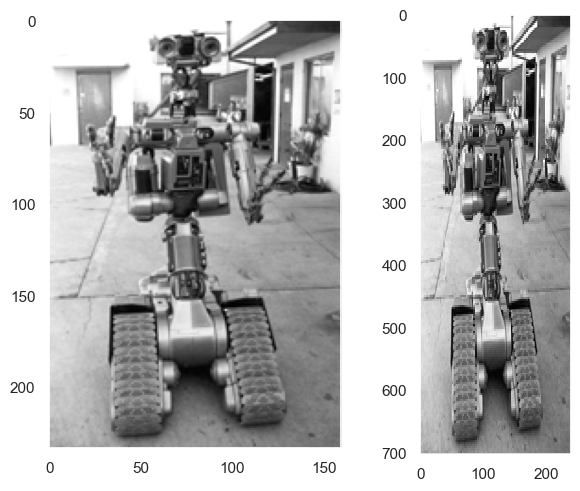

In [21]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(gray, cmap='gray', vmin=0, vmax=255);
axes[1].imshow(gray_scl, cmap='gray', vmin=0, vmax=255, interpolation='none');

## Skew

In [22]:
phi_skw = -15. / 180. * np.pi
A_skw = np.array([
    [1., np.tan(phi_skw), abs(gray.shape[0] * np.tan(phi_skw)) if phi_skw < 0 else 0.],
    [0., 1., 0.],
    [0., 0., 1.],
])
A_skw

array([[ 1.   , -0.268, 62.7  ],
       [ 0.   ,  1.   ,  0.   ],
       [ 0.   ,  0.   ,  1.   ]])

In [23]:
gray_skw = warp_affine_inv(gray, A_skw)
gray_skw.shape, gray_skw.dtype

((234, 222), dtype('uint8'))

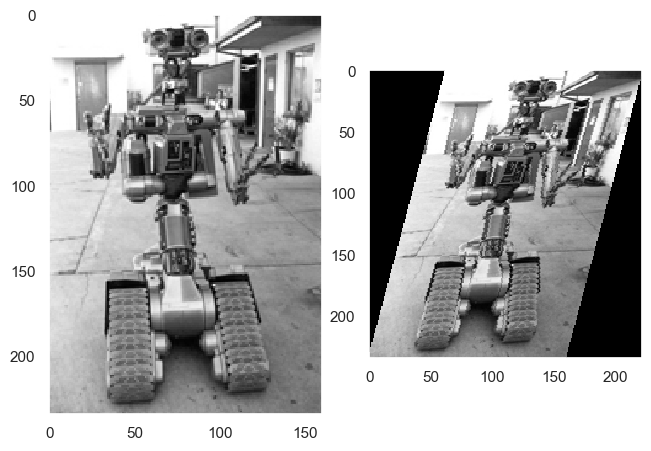

In [24]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(gray, cmap='gray', vmin=0, vmax=255, interpolation='none');
axes[1].imshow(gray_skw, cmap='gray', vmin=0, vmax=255, interpolation='none');

## Rotation

In [25]:
angle = 30. / 180. * np.pi
A_rot = np.array([
    [np.cos(angle), np.sin(angle), 0.,],
    [-np.sin(angle), np.cos(angle), 0.],
    [0., 0., 1.],
])
A_rot

array([[ 0.866,  0.5  ,  0.   ],
       [-0.5  ,  0.866,  0.   ],
       [ 0.   ,  0.   ,  1.   ]])

In [26]:
gray_rot = warp_affine_inv(gray, A_rot)
gray_rot.shape, gray_rot.dtype

((282, 255), dtype('uint8'))

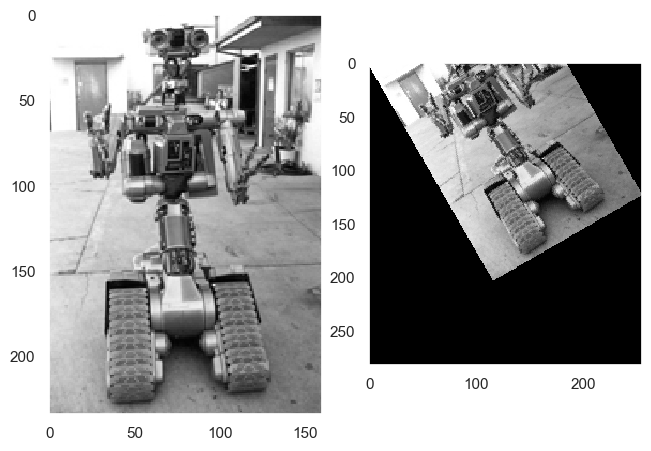

In [27]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(gray, cmap='gray', vmin=0, vmax=255, interpolation='none');
axes[1].imshow(gray_rot, cmap='gray', vmin=0, vmax=255, interpolation='none');

# Hierarchy of transformations

Based on the properties of the $3 \times 3$ transformation matrix, geometric transformations are usually classified into 4 categories.

**1. Euclidean transformations (isometries)**

Euclidean transformations represent rotation and translation.
$$
\begin{bmatrix}
    x' \\
    y' \\
    1
\end{bmatrix}
=
\begin{bmatrix}
    \pm \cos(\theta) & -\sin(\theta) & t_x \\
    \pm \sin(\theta) &  \cos(\theta) & t_x \\
    0 & 0 & 1
\end{bmatrix}
\cdot
\begin{bmatrix}
    x \\
    y \\
    1
\end{bmatrix}
\qquad
\textrm{or}
\qquad
\bold{x}'
=
\begin{bmatrix}
    \bold{R} & \bold{t} \\
    \bold{0}^\top & 1
\end{bmatrix}
\cdot
\bold{x}
$$
*Invariants*: Euclidean distance, angle and area.

**2. Similarity transformations**

Similarity transformations represent combination of scaling, rotation and translation.
$$
\begin{bmatrix}
     x' \\
     y' \\
     1
 \end{bmatrix}
 =
 \begin{bmatrix}
     s \cdot \cos(\theta) & -s \cdot \sin(\theta) & t_x \\
     s \cdot \sin(\theta) &  s \cdot \cos(\theta) & t_x \\
     0 & 0 & 1
 \end{bmatrix}
 \cdot
 \begin{bmatrix}
     x \\
     y \\
     1
 \end{bmatrix}
\qquad
\textrm{or}
\qquad
\bold{x}'
=
\begin{bmatrix}
    s \cdot \bold{R} & \bold{t} \\
    \bold{0}^\top & 1
\end{bmatrix}
\cdot
\bold{x}
$$
*Invariants*: angle, ratio of distances.

**3. Affine transformations**

Affine transformations represent combination of non-isotropic scaling, rotation and translation (and skewing included).
$$
\begin{bmatrix}
    x' \\
    y' \\
    1
\end{bmatrix}
=
\begin{bmatrix}
    a_{1,1} & a_{1,2} & t_x \\
    a_{2,1} & a_{2,2} & t_x \\
    0 & 0 & 1
\end{bmatrix}
\cdot
\begin{bmatrix}
    x \\
    y \\
    1
\end{bmatrix}
\qquad
\textrm{or}
\qquad
\bold{x}'
=
\begin{bmatrix}
    \bold{A} & \bold{t} \\
    \bold{0}^\top & 1
\end{bmatrix}
\cdot
\bold{x}
$$
*Invariants*: parallel lines, ratio of lengths of parallel line segments, ratio of areas.

**4. Projective transformations (homographies)**

In addition to transformations above, homographies can also represent out-of-image-plane rotations (perspective).
$$
\begin{bmatrix}
    z' \cdot x' \\
    z' \cdot y' \\
    z'
\end{bmatrix}
=
\begin{bmatrix}
    a_{1,1} & a_{1,2} & a_{1,3} \\
    a_{2,1} & a_{2,2} & a_{2,3} \\
    a_{3,1} & a_{3,2} & a_{3,3} \\
\end{bmatrix}
\cdot
\begin{bmatrix}
    x \\
    y \\
    1
\end{bmatrix}
\qquad
\textrm{or}
\qquad
\bold{x}'
=
\begin{bmatrix}
    \bold{A} & \bold{t} \\
    \bold{a}^\top & a_{3,3}
\end{bmatrix}
\cdot
\bold{x}
$$

*Invariants*: cross ratio of lengths on a line.

Notice that in case of projective transformations, the last element of the transformed vector $z'$ is not in general equal to one. In order to compute the final position, we need to normalize $x',y'$ by dividing the vector $\bold{x}'$ by $z'$.

See [scikit-image example](https://scikit-image.org/docs/stable/auto_examples/transform/plot_transform_types.html).

In [28]:
def warp_inv(img: np.ndarray, A: np.ndarray) -> np.ndarray:
    height, width = img.shape[:2]
    
    # get image corners and transform them
    X = np.array([0., width, width, 0.])
    Y = np.array([0., 0., height, height])
    XY = np.vstack((X, Y, np.ones(4)))
    XY_ = np.dot(A, XY)
    XY_ /= XY_[-1, :]
    ox_, oy_ =  XY_[0, :].min(),  XY_[1, :].min()
    
    # calculate the new size
    width_ = int(XY_[0, :].max() - XY_[0, :].min())
    height_ = int(XY_[1, :].max() - XY_[1, :].min())
    img_ = np.zeros((height_, width_), dtype=img.dtype)
    
    # invert transformation
    A_inv = np.linalg.inv(A)

    # helper function to safely get a value gray[y, x]
    def src_img_at(x, y):
        if 0 <= x < width and 0 <= y < height:
            return img[y, x]
        else:
            return 0
    
    # the main transformation loop
    for y_ in range(height_):
        for x_ in range(width_):
            # inverse transform
            x, y, z = np.dot(A_inv, [x_ + ox_, y_ + oy_, 1.])
            # normalize homogennous coordinates
            x /= z
            y /= z
            # round
            x = int(0.5 + x)
            y = int(0.5 + y)    
            img_[y_, x_] = src_img_at(x, y)  # src_img_at defined on line 19 of this function
    
    return img_

In [29]:
A_hom = np.array([
    [ 0.9, -0.3, 50.],
    [-0.5,  1.0, 30.],
    [-0.002, -0.0015, 1]
])

In [30]:
gray_hom = warp_inv(gray, A_hom)
gray_hom.shape, gray_hom.dtype

((632, 407), dtype('uint8'))

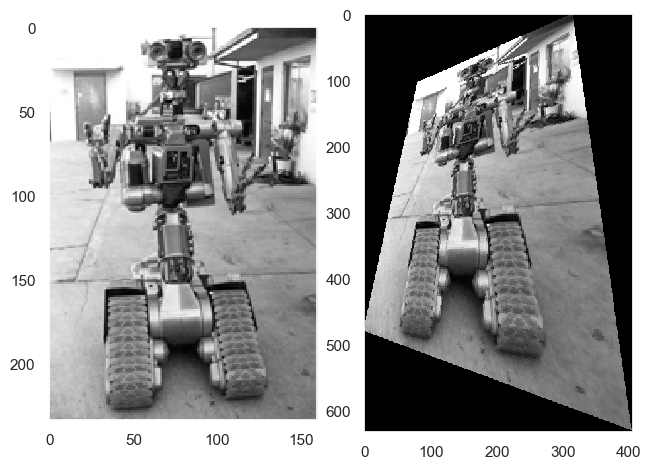

In [31]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(gray, cmap='gray', vmin=0, vmax=255, interpolation='none');
axes[1].imshow(gray_hom, cmap='gray', vmin=0, vmax=255, interpolation='none');

In [32]:
def homography_interact(
        a11: float = 1., a12: float = 0., a13: float = 0.,
        a21: float = 0., a22: float = 1., a23: float = 0.,
        a31: float = 0., a32: float = 0., a33: float = 1.,
):
    A_hom = np.array([
        [a11, a12, a13],
        [a21, a22, a23],
        [a31, a32, a33],
    ])
    plt.imshow(warp_inv(gray, A_hom), cmap='gray', vmin=0, vmax=255, interpolation='none')
    return A_hom

ipywidgets.interact(
    homography_interact,
    a11=(-1., 1., 0.01), a12=(-1., 1., 0.01), a13=(-1., 1., 0.01),
    a21=(-1., 1., 0.01), a22=(-1., 1., 0.01), a23=(-1., 1., 0.01),
    a31=(-0.01, 0.01, 0.0001), a32=(-0.01, 0.01, 0.0001), a33=(-1., 1., 0.01),
    readout_format='.3f'
);

interactive(children=(FloatSlider(value=1.0, description='a11', max=1.0, min=-1.0, step=0.01), FloatSlider(val…

# Brightness interpolation

What is the value of $I(x, y)$ when $\{x, y\} \not\subset \mathbb{Z}^{+}$, i.e. $(x, y)$ are non-integer real numbers? In such cases we say we *interpolate* the off-grid values,
$$
\tilde{I}(x, y) = \text{interpolate}(I, x, y)
$$

**Nearest neighbor interpolation**

In the code above, we made sure we stayed in the discrete image grid by rounding the transformed $(x,y)$ coordinates to the nearest integer. Formally, this is called nearest neighbor interpolation, where
$$
\tilde{I}(x, y) = I\left( \left\lfloor x \right\rceil, \left\lfloor y \right\rceil \right)
$$
where $\left\lfloor\cdot\right\rceil$ denotes rounding to nearest integer.

**Linear interpolation**

For visually better looking and smoother non-pixelated results, we may perform a linear interpolation. For some 1D function $f$, the interpolation is
$$
\tilde{f}(x) = (1 - d_x) \cdot f(x) + d_x \cdot f(x+1)
$$
where $d_x = x - \lfloor x\rfloor$. In other words, values inbetween two discrete positions are a weighted average of nearest samples, with the weights being negatively proportional to the distance from either of the two integer positions. See the following image.

<img src="figures/geom_transform-interpolation.png" alt="Interpolation" style="width: 6in;"/>

In 2D, we have so called *bilinear interpolation*
$$
\begin{matrix}
\tilde{I}(x,y) = &   & (1-d_x) & \cdot & (1-d_y) & \cdot & I(x,y) \\
                 & + & d_x     & \cdot & (1-d_y) & \cdot & I(x+1,y) \\
                 & + & (1-d_x) & \cdot & d_y     & \cdot & I(x,y+1) \\
                 & + & d_x     & \cdot & d_y     & \cdot & I(x+1,y+1)
\end{matrix}
$$
where instead of just two pixels, we have to take into account *four* nearest image samples.

Bilinear interpolation is illustrated in the following figure.

<img src="figures/geom_transformations-bilinear_interpolation.png" alt="Bilinear interpolation" style="width: 6in;"/>

**Interpolation as convolution**

Interpolation can be expressed as a convolution of a continuous kernel function $w(x)$ with a discrete image function $f(u)$
$$
\tilde{f}(x) = (w * f)(x) = \sum_{u=-\infty}^{+\infty}{w(u - x)\cdot f(u)}
$$
It is then the kernel function $w(x)$ that defines which particular interpolation will be performed. For example, *nearest neighbor interpolation* has
$$
w_\textrm{nn}(x) = \begin{cases}
    1 & \textrm{for} \quad -0.5 \le x \lt 0.5 \\
    0 & \textrm{otherwise}
\end{cases}
$$
*Linear interpolation* is
$$
w_\textrm{nn}(x) = \begin{cases}
    1 - |x| & \textrm{for} \quad |x| \lt 1 \\
    0 & \textrm{otherwise}
\end{cases}
$$
*Cubic interpolation* is
$$
w_\textrm{cub}(x,a) = \begin{cases}
    (-a + 2)\cdot |x|^3 + (a-3)\cdot x^2 + 1 & \textrm{for} \quad 0 \le |x| \lt 1 \\
    -a \cdot |x|^3 + 5a \cdot x^2 - 8a \cdot |x| + 4a & \textrm{for} \quad 1 \le |x| \lt 2 \\
    0 & \textrm{otherwise}
\end{cases}
$$

# Geometric transformations in scikit-image

Remarks:
- the `skimage.transform.warp` function will *not* calculate the output dimensions for us $\rightarrow$ we have to provide them
- similarly with transformation matrix $\bold{A}^{-1}$, we have to invert ourselves, the function will not do it for us
- interpolation is specified by the `order` argument
- the function works with RGB images

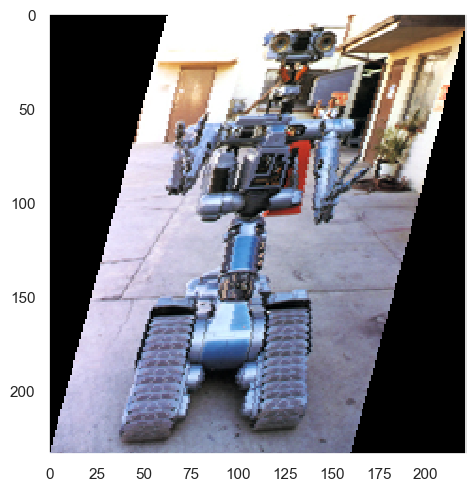

In [33]:
plt.imshow(
    skimage.transform.warp(rgb, np.linalg.inv(A_skw), output_shape=gray_skw.shape, order=0),
    interpolation = 'none'
);

# Geometric transformations in OpenCV

Remarks:
- the function is `warpAffine`
- similarly to scikit-image, we need to calculate the output dimensions manually and pass them into the function
- by default, the function expects *forward* matrix $\bold{A}$, i.e. it will invert automatically

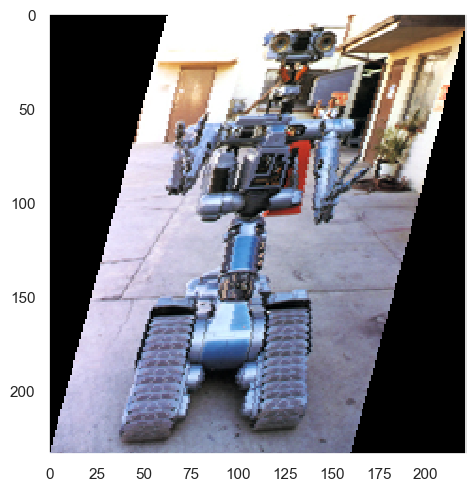

In [34]:
plt.imshow(
    cv2.warpAffine(rgb, A_skw[:2, :], (gray_skw.shape[1], gray_skw.shape[0]), flags=cv2.INTER_NEAREST), 
    interpolation='none'
);

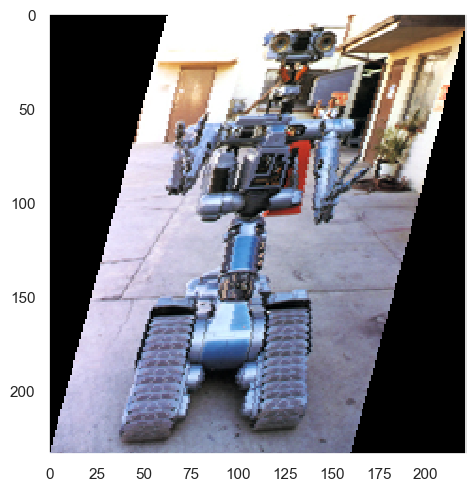

In [35]:
# the same just with the inverse version of the transformation matrix
plt.imshow(
    cv2.warpAffine(rgb, np.linalg.inv(A_skw)[:2, :], (gray_skw.shape[1], gray_skw.shape[0]), flags=cv2.WARP_INVERSE_MAP),
    interpolation='none'
);

# Acceleration using numba

In [36]:
@jit(nopython=True)
def warp_inv_numba(img, A):
    height, width = img.shape
    
    # get image corners and transform them, i.e. see the cell above
    X = np.array([0., width, width, 0.])
    Y = np.array([0., 0., height, height])
    XY = np.vstack((X, Y, np.ones(4)))
    XY_ = np.dot(A, XY)
    XY_ /= XY_[-1, :]
    ox_, oy_ =  XY_[0, :].min(),  XY_[1, :].min()
    
    # calculate the new size
    width_ = int(XY_[0, :].max() - XY_[0, :].min())
    height_ = int(XY_[1, :].max() - XY_[1, :].min())
    img_ = np.zeros((height_, width_), dtype=img.dtype)
    
    A_inv = np.linalg.inv(A)
    
    # the main transformation loop
    for y_ in range(height_):
        for x_ in range(width_):
            # inverse transform
            x, y, z = np.dot(A_inv, np.array([x_ + ox_, y_ + oy_, 1.]))
            # normalize homogennous coordinates
            x /= z
            y /= z

            # nearest neighbor interpolation
            x = int(0.5 + x)
            y = int(0.5 + y)
            
            # check the limits
            if 0 <= x < width and 0 <= y < height:
                img_[y_, x_] = img[y, x]
    
    return img_

In [37]:
alpha = 2.5

A_scl = np.array([
    [alpha, 0., 0.],
    [0., alpha, 0.],
    [0., 0., 1.],
])

In [38]:
# run this cell at least twice, the first time is slowed down by JIT compilation
scaled = warp_inv_numba(gray, A_scl)

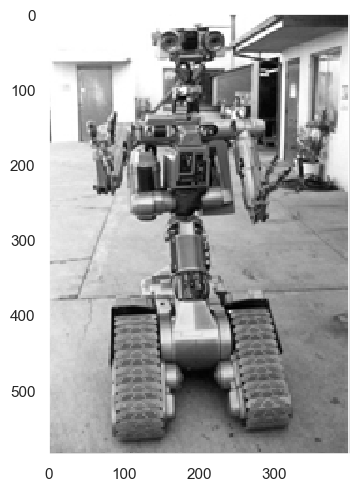

In [39]:
plt.imshow(scaled, cmap='gray', vmin=0, vmax=255, interpolation='none');

In [40]:
%timeit warp_inv(gray, A_scl)
%timeit warp_inv_numba(gray, A_scl)

969 ms ± 51.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
72.7 ms ± 2.64 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
skewed = warp_inv_numba(gray, A_skw)

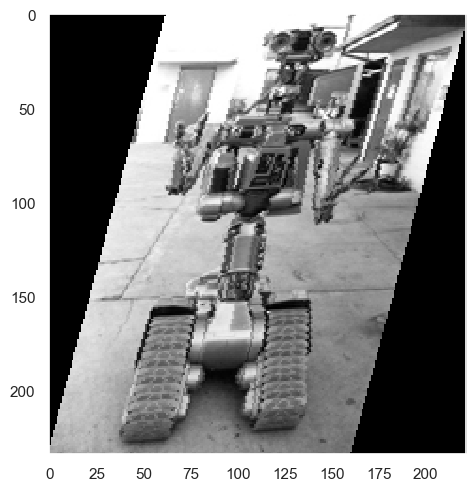

In [42]:
plt.imshow(skewed, cmap='gray', vmin=0, vmax=255, interpolation='none');

# Transformation estimation

Imagine that we want to read name and surname from a photo of an ID card, that is not perfectly upright and might even be rotated outside of the image plane. In other words, we would like to extract a square or rectangular region from an image and register it to a standard coordinate system and size using a geometric transform. The problem is, however, that we don't know the values of the homography matrix $\bold{A}$. Fortunately, we can estimate it, provided that we know, for example, the positions of 4 corners of the ID card.

Input:
- positions $x_0', y_0', \ldots, x_4', y_4'$ of the corners of the ID card
- positions $x_0, y_0, \ldots, x_4, y_4$ of the corners of the standard frame (like upright normalized view of the ID card)

Uknown:
- homography matrix $\bold{A}$

To estimate a projective tranform from a set of 4 correspondences, we can rewrite the transformation
$$
\begin{bmatrix}
    z_i' \cdot x_i' \\
    z_i' \cdot y_i' \\
    z_i'
\end{bmatrix}
=
\begin{bmatrix}
    a_{1,1} & a_{1,2} & a_{1,3} \\
    a_{2,1} & a_{2,2} & a_{2,3} \\
    a_{3,1} & a_{3,2} & a_{3,3} \\
\end{bmatrix}
\cdot
\begin{bmatrix}
    x_i \\
    y_i \\
    1
\end{bmatrix},
\qquad
i = 1, \ldots, 4
$$
as the following system of linear equations and then solve for the unknown vector of coefficents $\bold{a}$
$$
\begin{bmatrix}
x_0 & y_0 &  1  &  0  &  0  &  0  & -x_0\cdot x_0' & -y_0\cdot x_0' \\
 0  &  0  &  0  & x_0 & y_0 &  1  & -x_0\cdot y_0' & -y_0\cdot y_0' \\
x_1 & y_1 &  1  &  0  &  0  &  0  & -x_1\cdot x_1' & -y_1\cdot x_1' \\
0  &  0  &  0  & x_1 & y_1 &  1  & -x_1\cdot y_1' & -y_1\cdot y_1' \\
x_2 & y_2 &  1  &  0  &  0  &  0  & -x_2\cdot x_2' & -y_2\cdot x_2' \\
 0  &  0  &  0  & x_2 & y_2 &  1  & -x_2\cdot y_2' & -y_2\cdot y_2' \\
x_3 & y_3 &  1  &  0  &  0  &  0  & -x_3\cdot x_3' & -y_3\cdot x_3' \\
0  &  0  &  0  & x_3 & y_3 &  1  & -x_3\cdot y_3' & -y_3\cdot y_3'
\end{bmatrix}
\cdot
\begin{bmatrix}
a_{0,0} \\
a_{0,1} \\
a_{0,1} \\
a_{1,0} \\
a_{1,1} \\
a_{1,2} \\
a_{2,0} \\
a_{2,1}
\end{bmatrix}
=
\begin{bmatrix}
x_0' \\
y_0' \\
x_1' \\
y_1' \\
x_2' \\
y_2' \\
x_3' \\
y_3' \\
\end{bmatrix}
$$

Instead of an ID card, we will apply the above procedure to the Sudoku game.

## Estimation in scikit-image

In [45]:
rgb = cv2.imread('CA10_01.jpg')[..., ::-1]
rgb.dtype, rgb.shape

(dtype('uint8'), (1920, 1080, 3))

In [46]:
# we will define corners of the region in the original image in homogenous form as source points
src_xy = np.array(
    [
        (267, 644),
        (941, 887),
        (784, 1310),
        (96, 1047)
    ],
    dtype=np.float32
)
src_xy

array([[ 267.,  644.],
       [ 941.,  887.],
       [ 784., 1310.],
       [  96., 1047.]], dtype=float32)

In [47]:
# select target size (height x width)
dst_shape = 420, 669

In [48]:
# target points will be corners of the resulting image
dst_xy = np.array(
    [
        (0, 0),
        (dst_shape[1], 0),
        (dst_shape[1], dst_shape[0]),
        (0, dst_shape[0])
    ],
    dtype=np.float32
)
dst_xy

array([[  0.,   0.],
       [669.,   0.],
       [669., 420.],
       [  0., 420.]], dtype=float32)

In [49]:
tform = skimage.transform.estimate_transform('projective', src_xy, dst_xy)
tform.params  # homography matrix

array([[   0.939,    0.399, -507.45 ],
       [  -0.354,    0.983, -538.485],
       [   0.   ,    0.   ,    1.   ]])

In [50]:
roi = skimage.transform.warp(rgb, np.linalg.inv(tform.params), output_shape=dst_shape)
roi.shape

(420, 669, 3)

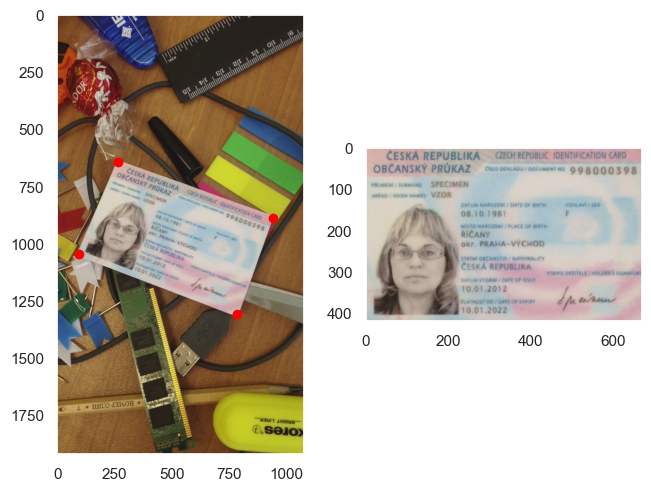

In [51]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(rgb)
axes[0].plot(src_xy[:, 0], src_xy[:, 1], 'o', color=(1, 0, 0));
axes[1].imshow(roi);